# ICA Denoise Development

This notebook outlines the ICA denoising process for a single subject with additional diagnostic and analysis information.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
import pickle as pkl

from Cho2017 import SubjectData


pickle_cache_dir = 'denoise_classify_data'
subject_data_pickle_path = lambda n: os.path.join(pickle_cache_dir, 'data_{}.pkl'.format(n))
subject_ica_pickle_path = lambda n: os.path.join(pickle_cache_dir, 'ica_{}.pkl'.format(n))


plt.rcParams['figure.figsize'] = [12, 8]

# # Make sure ipympl is installed (via pip) for interactive plots in Jupyter 
# %matplotlib widget

## ICA Denoise Parameters

In [2]:
ICA_SEED = 97 # Just some random seed
SPLIT_SEED = 42
CORRMAP_THRESH = 0.8
n_ica_comps = 64
N_TEMPLATE_ICS = 10
picks = ['FP1', 'FPZ', 'FP2', 'C3', 'Cz', 'C4']

## Load data

In [3]:
subj_n = 3
subject = SubjectData('Cho2017-Data/s{:02d}.mat'.format(subj_n))

In [4]:
tmin = -1
tmax = 4
filter_freq = (1, None)   # Literature reccomends high passing above 1Hz to remove bias from signal prior to ICA fitting

im_left_epochs = subject.get_epochs('imagery_left', tmin=tmin, tmax=tmax, picks=['eeg'], filter_freqs=filter_freq, reject_criteria=None, verbose=False)
im_right_epochs = subject.get_epochs('imagery_right', tmin=tmin, tmax=tmax, picks=['eeg'], filter_freqs=filter_freq, reject_criteria=None, verbose=False)
# Set left events to 0 to have 2 distinct class labels (left: 0 and right: 1) for classification
im_left_epochs.events[:, -1] = 0
im_left_epochs.event_id = {'0': 0}
joint_im_epochs = mne.concatenate_epochs([im_left_epochs.copy(), im_right_epochs.copy()], add_offset=True)

100 events found
Event IDs: [1]
100 events found
Event IDs: [1]


## Get ICA Components from MI trial

Loading denoise_classify_data/ica_3.pkl


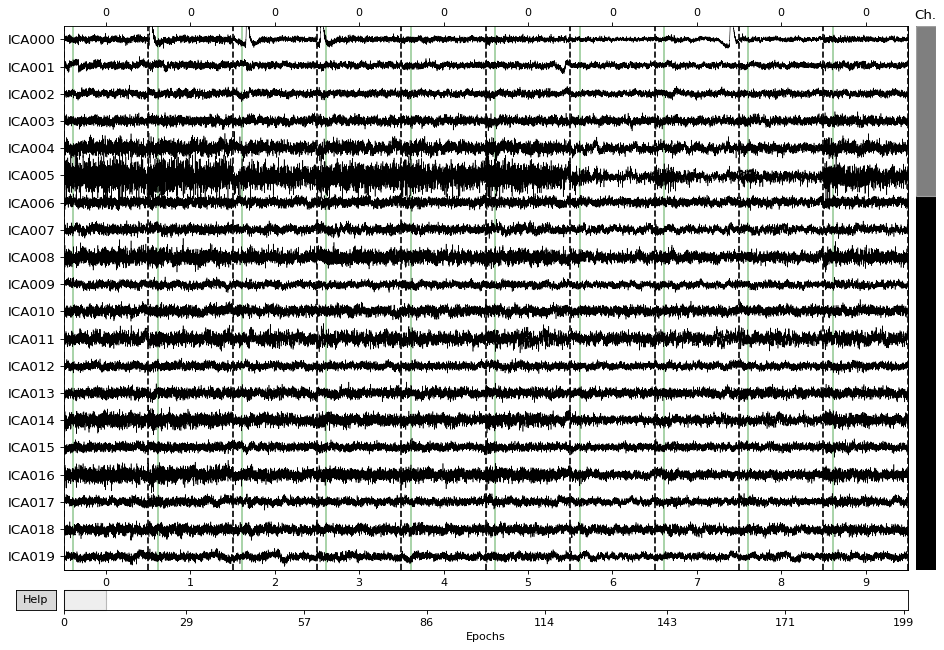

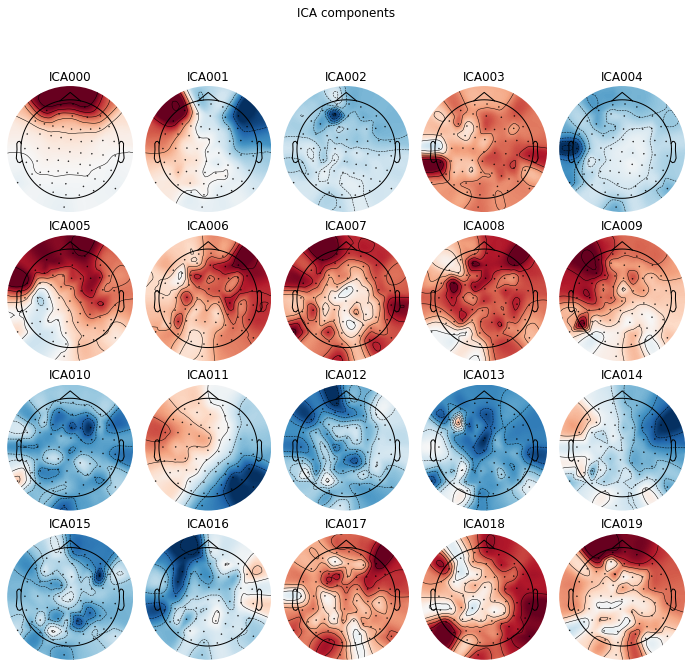

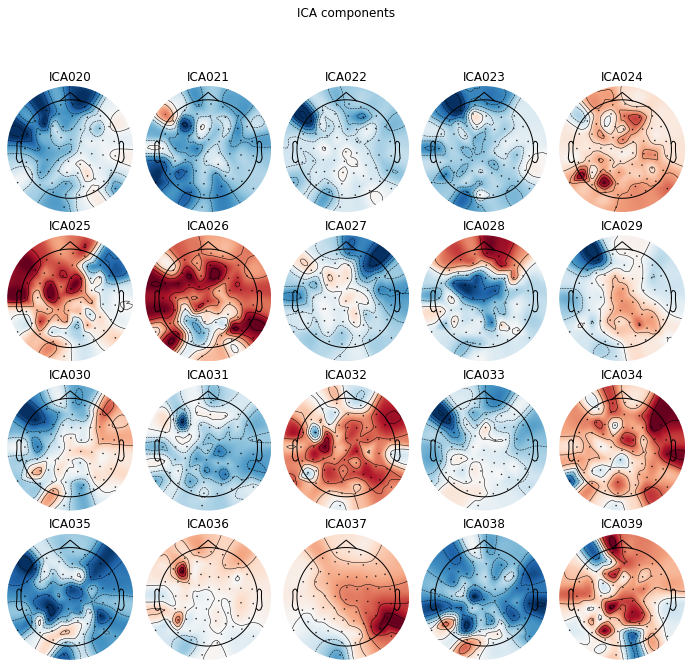

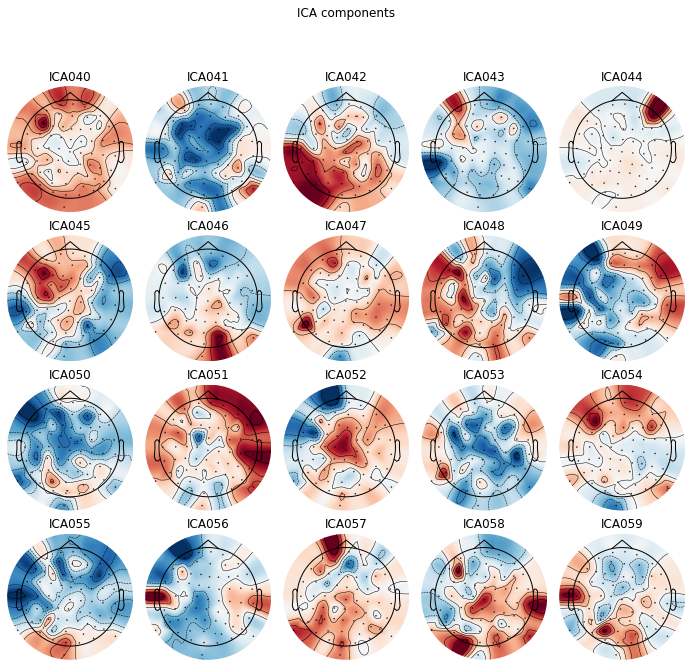

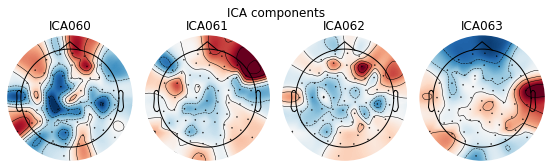

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
200

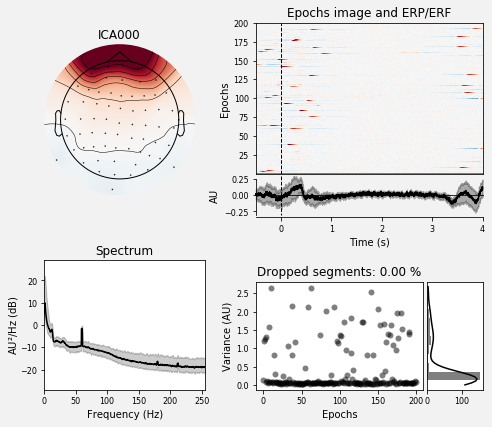

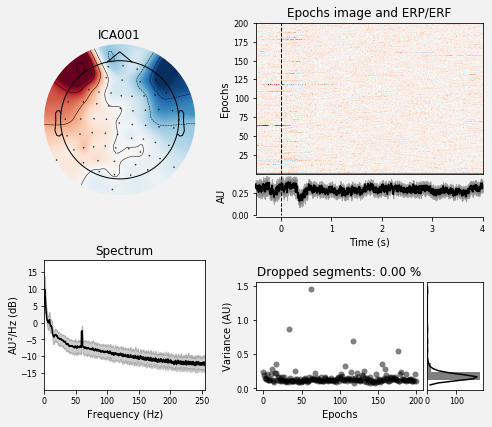

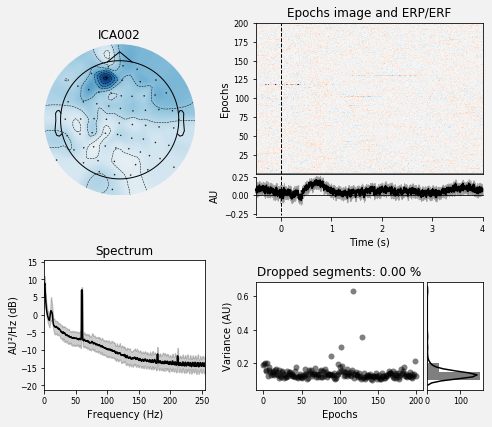

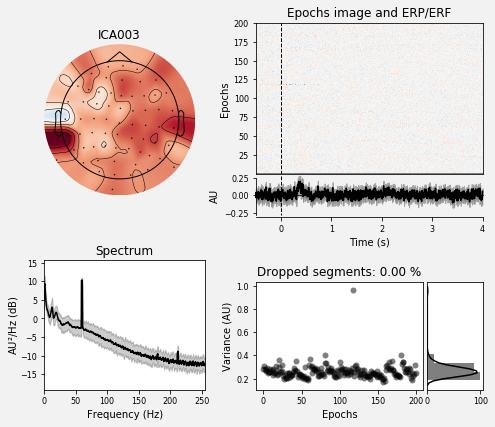

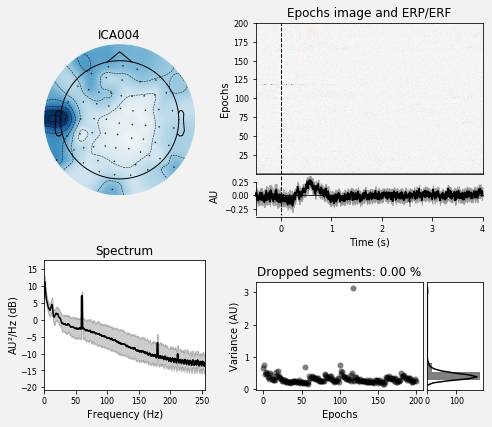

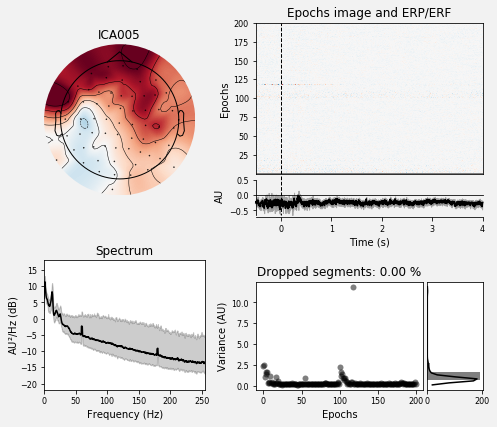

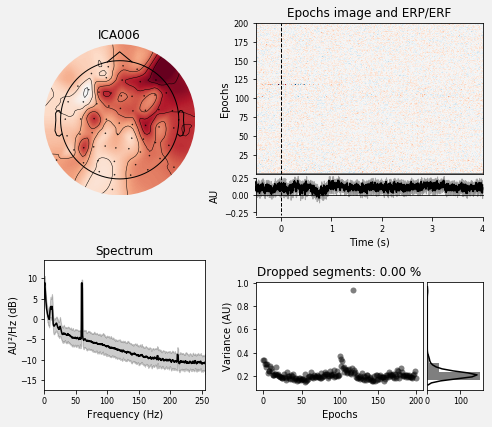

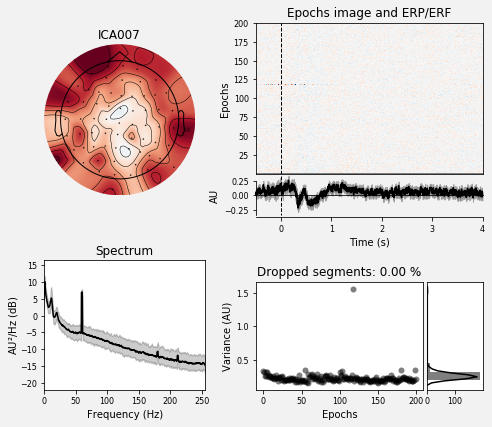

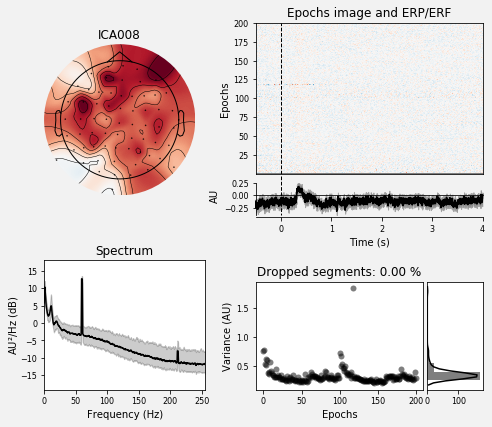

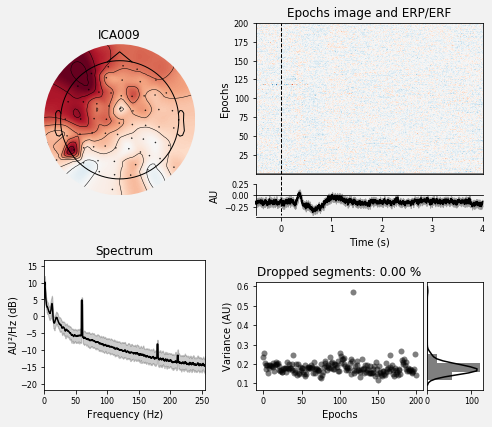

In [5]:
# ica = mne.preprocessing.ICA(n_components=n_ica_comps, random_state=ICA_SEED, max_iter=1000)
# ica.fit(joint_im_epochs)

with open(subject_ica_pickle_path(subj_n), 'rb') as f:
    print('Loading', subject_ica_pickle_path(subj_n))
    ica = pkl.load(f)
            
ica.plot_sources(joint_im_epochs, stop=N_TEMPLATE_ICS);
ica.plot_components();
ica.plot_properties(joint_im_epochs, picks=list(range(N_TEMPLATE_ICS)));

## Attempt denoising by manually selecting component(s) to drop

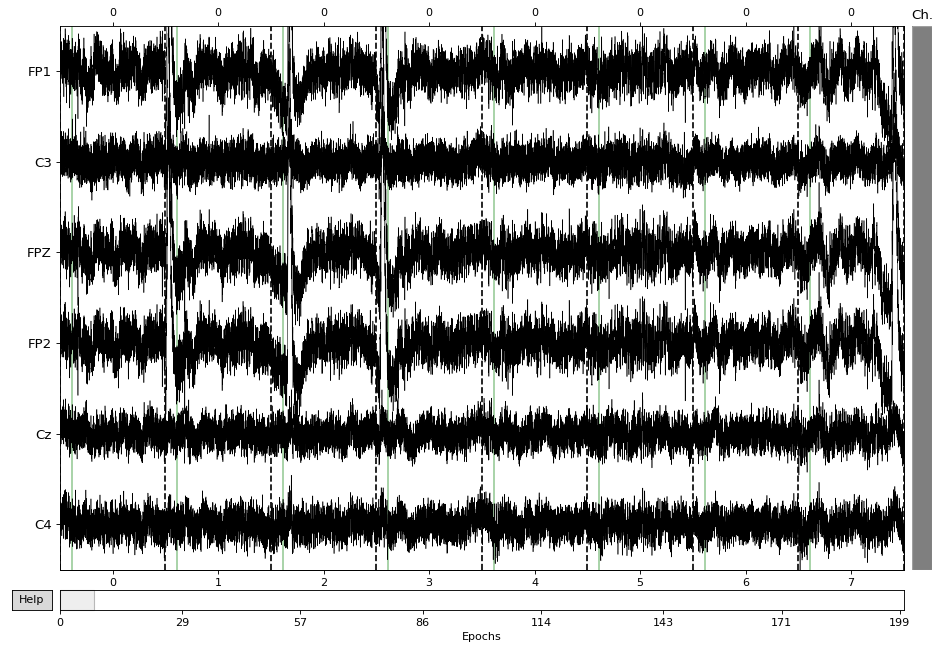

Transforming to ICA space (64 components)
Zeroing out 1 ICA component


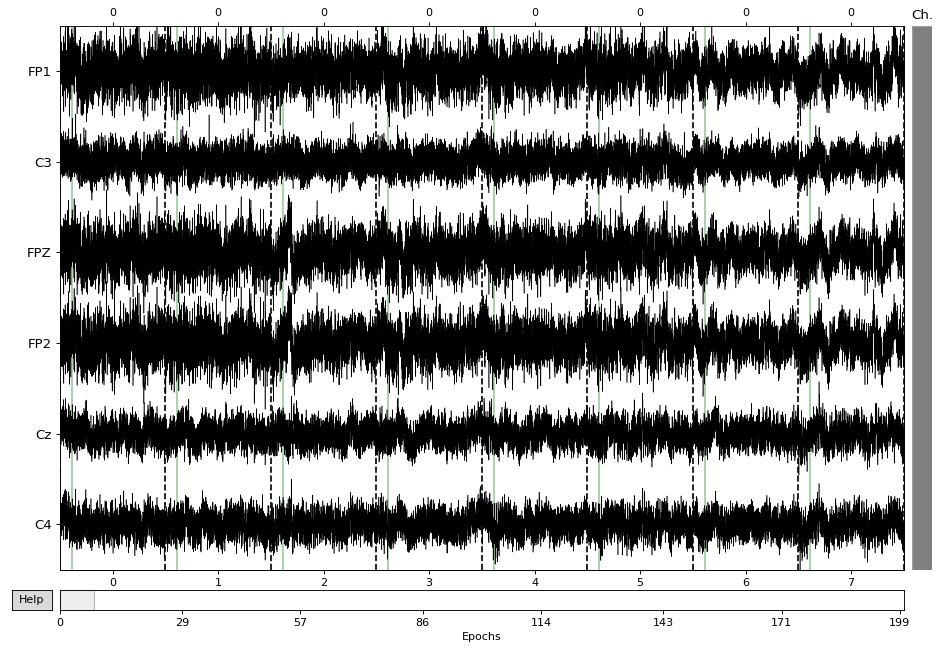

In [6]:
ica.exclude = [0]

joint_im_epochs.plot(n_epochs=8, picks=picks);            # The before (raw data)
denoised_joint_im_epochs = ica.apply(joint_im_epochs.copy())
denoised_joint_im_epochs.plot(n_epochs=8, picks=picks);   # After denoising

## Perform standard preprocessing and try and classify the denoised signals

In [7]:
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne.decoding import CSP, UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

In [8]:
reject_criteria = {'eeg': 100e-6}
filter_freqs = (7, 30)
filter_props = dict(picks=['eeg'], fir_design='firwin', skip_by_annotation='edge')

data = denoised_joint_im_epochs.filter(*filter_freqs, **filter_props).drop_bad(reject=reject_criteria).get_data()
data = UnsupervisedSpatialFilter(PCA()).fit_transform(data)
labels = denoised_joint_im_epochs.events[:, -1]

cv = ShuffleSplit(10, test_size=0.2, random_state=SPLIT_SEED)
cv_split = cv.split(data)

In [9]:
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)   # Cho 2017 uses 2 components per class
lda = LinearDiscriminantAnalysis()

clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, data, labels, cv=cv, n_jobs=8, error_score='raise')

In [10]:
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))

Classification accuracy: 0.800000 / Chance level: 0.500000


In [11]:
print(data.shape)
print(labels.shape, labels)
print(scores)

(200, 64, 2305)
(200,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.775 0.825 0.9   0.85  0.7   0.7   0.875 0.875 0.675 0.825]


## Applying Corrmap from noise trial and the MI trials to find bad components

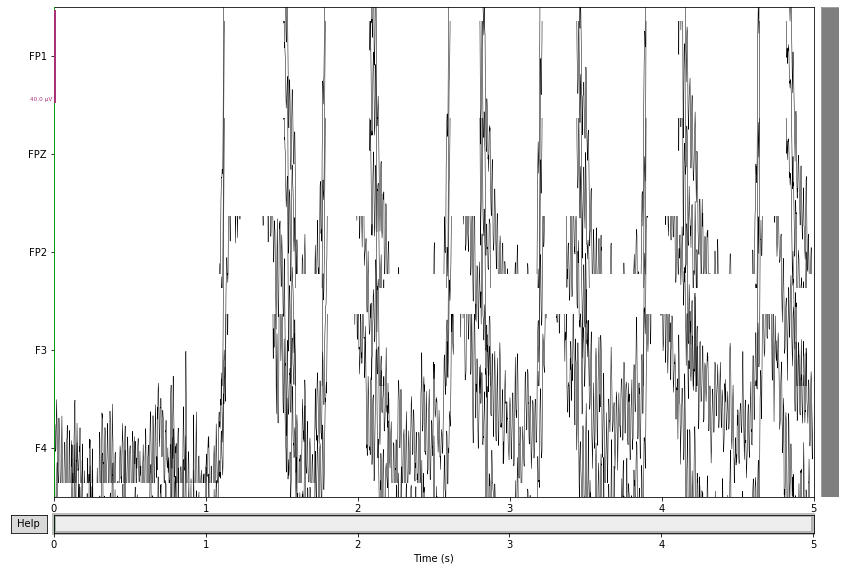

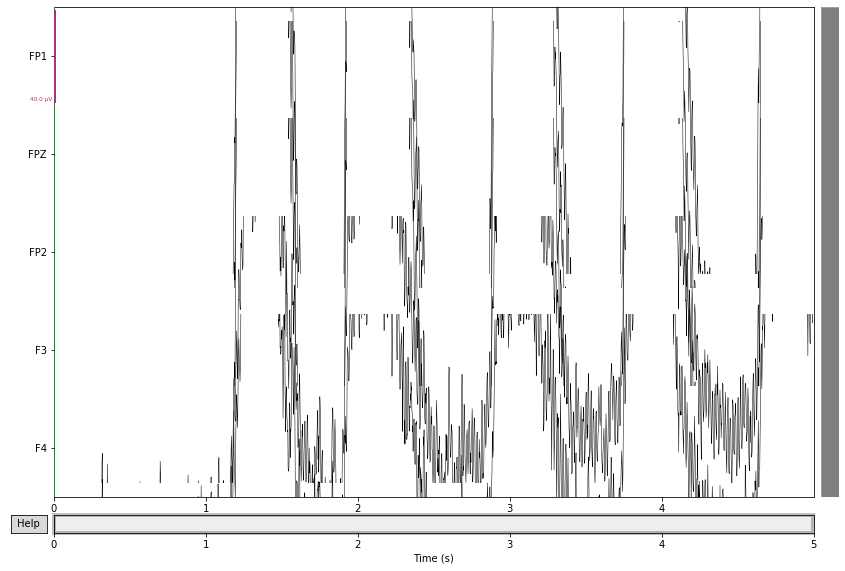

Using channel FP1 as EOG channel
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2561 samples (5.002 sec)

Now detecting blinks and generating corresponding events
Found 7 significant peaks
Number of EOG events detected : 7
Using channel FP1 as EOG channel
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
-------------------

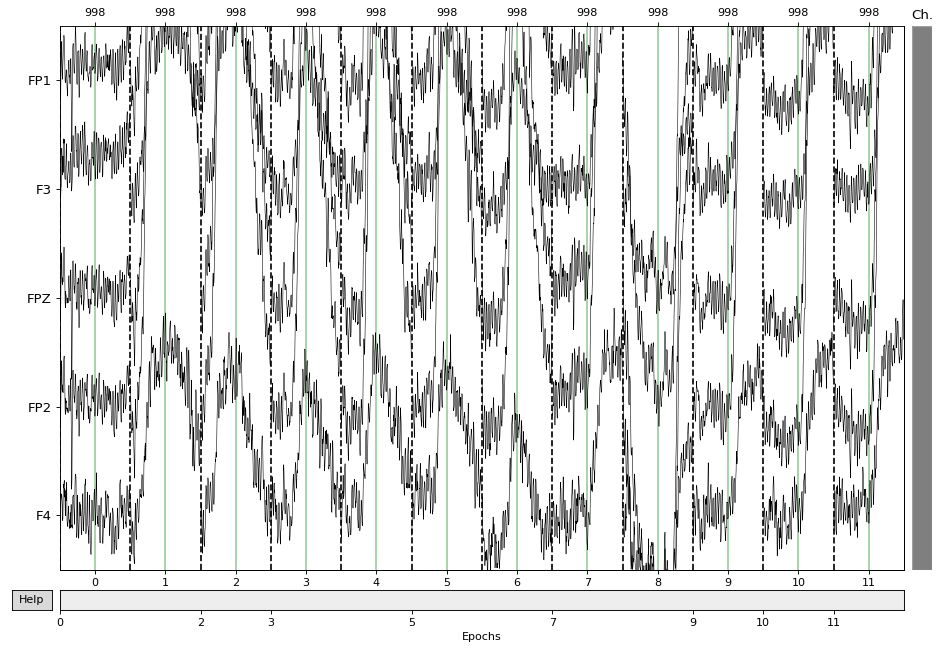

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 64 components
Fitting ICA took 2.4s.


<ICA | epochs decomposition, fit (fastica): 3084 samples, 64 components, channels used: "eeg">

In [12]:
picks = ['FP1', 'FPZ', 'FP2', 'F3', 'F4'] # None / ['eeg'] for first 20 channels or list of channel names for those specified channels

# Since blinking is performed in 2x 5s trials, it's possible the discontinuity at the trial boundary may be falsely marked as an EOG
blinking = [subject.raw_noise['blinking'].copy().crop(tmin=0, tmax=5), subject.raw_noise['blinking'].copy().crop(tmin=5, tmax=None)]
blinking[0].copy().pick(picks).plot();
blinking[1].copy().pick(picks).plot();

from mne import concatenate_epochs
from mne.preprocessing import find_eog_events
find_eog_ch = 'FP1'
tmin = -0.25
tmax = 0.25
baseline_toffset = 0.01

trial0_blink_events = find_eog_events(blinking[0], ch_name=find_eog_ch, filter_length=2561)    # Match filter length to length of signal
trial1_blink_events = find_eog_events(blinking[1], ch_name=find_eog_ch, filter_length=2560)

trial0_blink_epochs = mne.Epochs(blinking[0], trial0_blink_events, tmin=tmin, tmax=tmax, baseline=(tmin, tmin+baseline_toffset), reject=None, preload=True)
trial1_blink_epochs = mne.Epochs(blinking[1], trial1_blink_events, tmin=tmin, tmax=tmax, baseline=(tmin, tmin+baseline_toffset), reject=None, preload=True)
# trial0_blink_epochs.plot(picks=picks);
# trial1_blink_epochs.plot(picks=picks);

blink_epochs = concatenate_epochs([trial0_blink_epochs, trial1_blink_epochs])
blink_epochs.plot(picks=picks);

ica_blink = mne.preprocessing.ICA(n_components=n_ica_comps, random_state=97, max_iter=1000)
ica_blink.fit(blink_epochs)

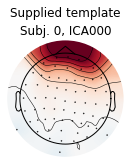

Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


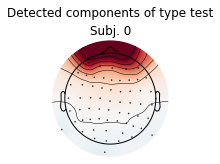

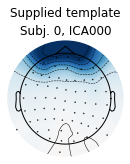

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


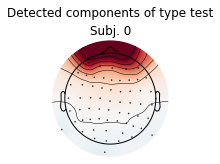

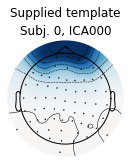

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


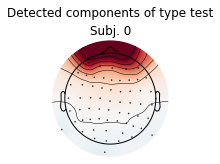

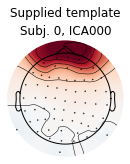

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


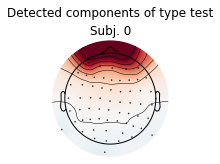

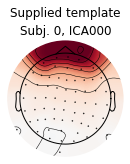

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


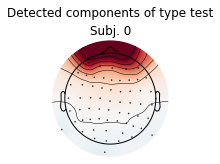

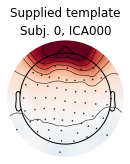

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


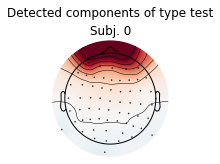

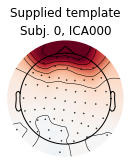

Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


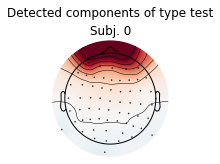

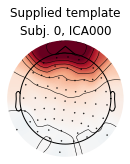

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


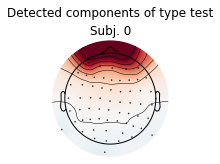

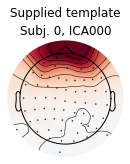

Median correlation with constructed map: 0.999
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


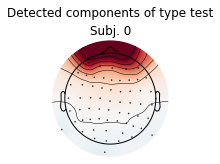

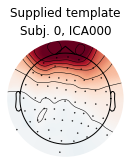

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


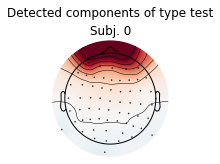

In [13]:
from mne.preprocessing import corrmap
for i in range(N_TEMPLATE_ICS):
    print('============================================================')
    corrmap([ica], ica_blink.get_components()[:, i], label='test');

In [14]:
ica.labels_['test']

[0]